<a href="https://colab.research.google.com/github/WalidYaser/Deep-Learning/blob/main/walid%20yasser%20/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

جاري تحميل البيانات من Francesco/bone-fracture-7fylg...


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- هيكل النموذج (VGG16 Architecture) ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Custom_Dense_ReLU (Dense)       │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Regularization          │ (None, 256)            │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Sigmoid (Dense)          │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

-----------------------------------------

جاري بدء عملية التدريب باستخدام VGG16...
Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - accuracy: 0.7573 - loss: 14.3539 - val_accuracy: 0.9688 - val_loss: 9.3710
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.9612 - loss: 10.9380 - val_accuracy: 0.9688 - val_loss: 1.9705
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 426ms/step - accuracy: 0.9584 - loss: 2.7698 - val_accuracy: 0.8750 - val_loss: 0.2260
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - accuracy: 0.8912 - loss: 0.3579 - val_accuracy: 1.0000 - val_loss: 0.1039
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.9842 - loss: 0.2389 - val_accuracy: 0.9688 - val_loss: 0.0435
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.9288 - loss: 0.3089 - val_accuracy: 0.9688 - val_loss: 0.0750
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.9522 - loss: 0.2091 - val_accuracy: 0.9688 - val_loss: 0.1288
Epoch 8/15
10/10 

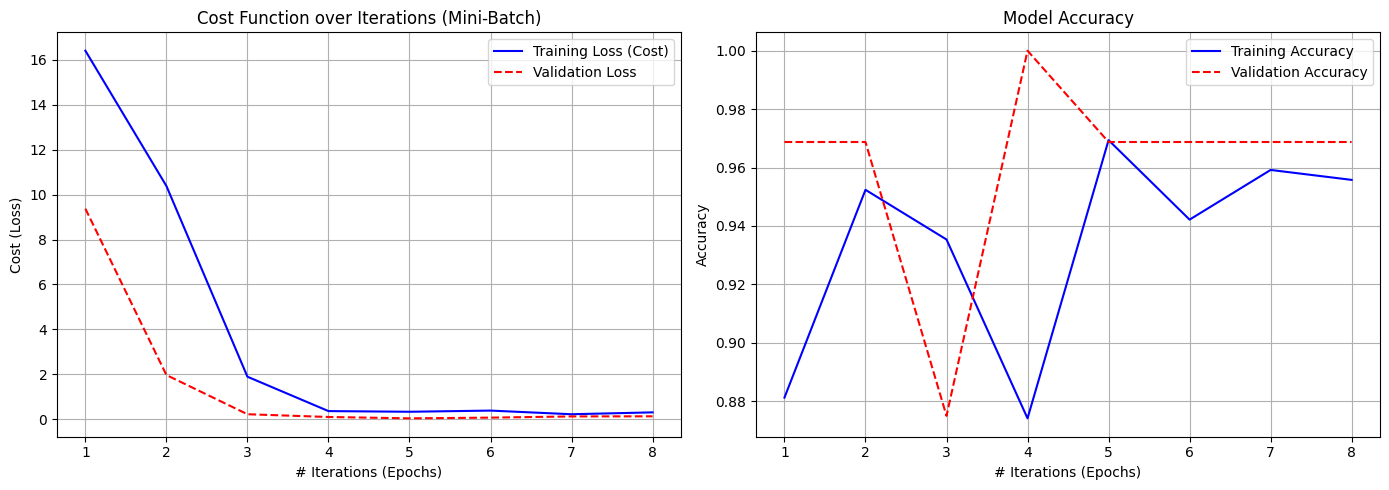

In [2]:
import tensorflow as tf
from datasets import load_dataset
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, RandomFlip, RandomRotation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ==========================================
# 1. تحميل الداتا سيت وتجهيزها (Mini-Batch Concept)
# ==========================================
hf_dataset_path = "Francesco/bone-fracture-7fylg"
print(f"جاري تحميل البيانات من {hf_dataset_path}...")
dataset = load_dataset(hf_dataset_path)

train_data = dataset['train']
val_data = dataset['validation']

def preprocess_image(element):
    image = element['image']
    objects = element['objects']

    # تحديد التصنيف بناءً على وجود كسر (1) أو عدمه (0)
    label = 1 if len(objects['category']) > 0 else 0

    if image.mode != 'RGB':
        image = image.convert('RGB')

    # تغيير الحجم ليناسب VGG16
    image = tf.image.resize(tf.keras.preprocessing.image.img_to_array(image), [224, 224])

    # المعالجة المسبقة الخاصة بـ VGG16
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image, label

def gen_train():
    for ex in train_data: yield preprocess_image(ex)

def gen_val():
    for ex in val_data: yield preprocess_image(ex)

output_sig = (tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
              tf.TensorSpec(shape=(), dtype=tf.int64))

# [cite_start]تحديد حجم الدفعة بـ 32 لتطبيق Mini-Batch Gradient Descent [cite: 209-210]
batch_size = 32
train_ds = tf.data.Dataset.from_generator(gen_train, output_signature=output_sig).batch(batch_size).repeat()
val_ds = tf.data.Dataset.from_generator(gen_val, output_signature=output_sig).batch(batch_size).repeat()

steps_per_epoch = max(1, len(train_data) // batch_size)
validation_steps = max(1, len(val_data) // batch_size)

# ==========================================
# 2. بناء معمارية النموذج (VGG16 & Transfer Learning)
# ==========================================
# أ. [cite_start]استدعاء VGG16 وتجميد الطبقات الأساسية (Freezing Layers) [cite: 420-424]
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# ب. [cite_start]زيادة البيانات (Data Augmentation) كتقنية Regularization [cite: 50]
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
], name="Data_Augmentation")

# ج. دمج الطبقات لإنشاء النموذج الكامل
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)

# [cite_start]تحويل المصفوفات لمتجه مسطح (Flatten) [cite: 254-266]
x = Flatten(name="Flatten_Layer")(x)

# [cite_start]إضافة طبقة مخفية (Fully Connected) مع تنشيط ReLU [cite: 316-317]
x = Dense(256, activation='relu', name="Custom_Dense_ReLU")(x)

# [cite_start]إضافة Dropout لتقليل فرصة حفظ البيانات (Overfitting) [cite: 45]
x = Dropout(0.5, name="Dropout_Regularization")(x)

# [cite_start]طبقة الخرج مع تنشيط Sigmoid للتصنيف الثنائي [cite: 82, 318-319]
outputs = Dense(1, activation='sigmoid', name="Output_Sigmoid")(x)

model = Model(inputs, outputs)

# عرض هيكل النموذج
print("\n--- هيكل النموذج (VGG16 Architecture) ---")
model.summary()
print("-----------------------------------------\n")

# ==========================================
# 3. التجميع والتحسين (Optimization)
# ==========================================
# [cite_start]استخدام Adam Optimizer [cite: 167]
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ==========================================
# 4. التدريب مع الإيقاف المبكر (Early Stopping)
# ==========================================
# [cite_start]إيقاف التدريب عندما تبدأ خسارة التقييم بالزيادة [cite: 47-49]
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

print("جاري بدء عملية التدريب باستخدام VGG16...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)
print("تم التدريب بنجاح!")

# ==========================================
# 5. رسم منحنى التكلفة (Cost Function Curve)
# ==========================================
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    # [cite_start]رسم منحنى التكلفة (Cost Function) بشكل سلس [cite: 226-229]
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, 'b-', label='Training Loss (Cost)')
    plt.plot(epochs_range, val_loss, 'r--', label='Validation Loss')
    plt.title('Cost Function over Iterations (Mini-Batch)')
    plt.xlabel('# Iterations (Epochs)')
    plt.ylabel('Cost (Loss)')
    plt.legend()
    plt.grid(True)

    # رسم منحنى الدقة (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, 'r--', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('# Iterations (Epochs)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("جاري رسم منحنيات الأداء...")

plot_learning_curve(history)